In [ ]:
from numpy.random import seed as np_seed
np_seed(42)
from tensorflow.random import set_seed as tf_seed
tf_seed(42)

In [ ]:
from tensorflow import keras
from keras import activations
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing import image
from keras.layers import *
from keras.models import Sequential, Model

x_train shape : (50000, 32, 32, 3)
x_test shape : (10000, 32, 32, 3)
y_train shape : (50000, 10)
y_test shape : (10000, 10)
(32, 32, 3)


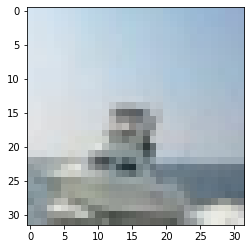

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print('x_train shape :', x_train.shape)
print('x_test shape :',x_test.shape)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

input_size = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(input_size)

plt.imshow(x_train[100])
plt.show()

In [ ]:
#GAN에서 generator와 discriminator를 구현할 때 필요한 기법들이 있다. generator의 마지막 layer의 activation function은 softmax나 sigmoid가 아닌 tanh를 쓰는 것 등

input = Input(input_size[1], name='InputLayer')

l = Dense(128 * 8 * 8, activation='LeakyReLU')(input)
l = Reshape((8, 8, 128))(l)

l = Conv2D(128, 5, padding='same', activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.8)(l)

l = UpSampling2D()(l)
l = Conv2DTranspose(256, 7, strides = 2, padding = 'same')(l)
l = Conv2D(256, 3, padding='same', activation='LeakyReLU')(l)
# b2 = BatchNormalization(momentum=0.8)(c2)

# l = Conv2D(64, 5, padding='same', activation='LeakyReLU')(l)
# l = UpSampling2D()(l)
# l = Conv2DTranspose(128, 5, padding='same', activation='LeakyReLU')(l)
l = Conv2D(128, 5 ,padding='same', activation='LeakyReLU')(l)
l = Conv2D(64, 5, padding='same', activation='LeakyReLU')(l)
l = Conv2D(x_train.shape[3], 5, padding='same', activation='tanh')(l)

G = Model(inputs=input, outputs=l, name='generator')

G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 8192)              270336    
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 128)         409728    
                                                                 
 up_sampling2d_2 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 256)      1605888   
 ranspose)                                               

In [ ]:
input = Input(shape=input_size)

l = Conv2D(32*2, 3, activation='LeakyReLU')(input)
# l = BatchNormalization(momentum=0.9)(l)
l = Dropout(0.25)(l)

l = Conv2D(32*4, 3, activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.9)(l)
l = Dropout(0.25)(l)

l = Conv2D(32*8, 3, activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.9)(l)
l = Dropout(0.25)(l)

l = Conv2D(32*16, 3, activation='LeakyReLU')(l)
# l = BatchNormalization(momentum=0.9)(l)

l = Flatten()(l)
# l = Dense(256, activation='relu')(l)
# l = Dense(128, activation='relu')(l)
# l = Dense(64, activation='relu')(l)
# l = Dense(32, activation='relu')(l)
l = Dropout(0.25)(l)
l = Dense(1, activation='softmax')(l)

D = Model(inputs=input, outputs=l, name='discriminator')

D.summary()

D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 dropout_13 (Dropout)        (None, 28, 28, 128)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 26, 26, 256)       295168    
                                                                 
 dropout_14 (Dropout)        (None, 26, 26, 256)     

In [ ]:
noise = Input(shape=(input_size[1],))
gan = Model(inputs=noise, outputs=D(G(noise)))
gan.summary()

gan_optimizer = keras.optimizers.Adam(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32)]              0         
                                                                 
 generator (Functional)      (None, 32, 32, 3)         3905027   
                                                                 
 discriminator (Functional)  (None, 1)                 1845889   
                                                                 
Total params: 5,750,916
Trainable params: 5,750,916
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 20
iterations = 1000
latent_dim = 32

random_vectors : (20, 32)
generated_images : (20, 32, 32, 3)
real_images: (20, 32, 32, 3)
discriminator loss at step 0 : [0.7052858471870422, 0.0]
gan loss at step 0 : 0.6209325790405273
discriminator loss at step 100 : [0.741481602191925, 0.0]
gan loss at step 100 : 0.9315422773361206
discriminator loss at step 200 : [0.5618687868118286, 0.0]
gan loss at step 200 : 2.481843948364258
discriminator loss at step 300 : [1.2224416732788086, 0.0]
gan loss at step 300 : 3.6210074424743652
discriminator loss at step 400 : [0.8103688955307007, 0.0]
gan loss at step 400 : 2.2484219074249268
discriminator loss at step 500 : [0.747349202632904, 0.0]
gan loss at step 500 : 2.672295093536377
discriminator loss at step 600 : [1.017095923423767, 0.0]
gan loss at step 600 : 4.28544282913208
discriminator loss at step 700 : [1.2316207885742188, 0.0]
gan loss at step 700 : 4.30739164352417
discriminator loss at step 800 : [0.4788500666618347, 0.0]
gan loss at step 800 : 7.642796516418457
discriminator l

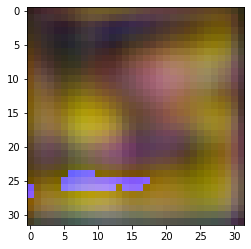

In [ ]:
with tf.device('/device:GPU:0'):
  start = 0
  for step in range(iterations):
      #batch size 개수 만큼의 normal distribution(정규분포)로 (batch_size, laten_dim)크기를 가진 random sample 생성
      random_vectors = np.random.normal(size=(batch_size, latent_dim))
      if step == 0: print('random_vectors :', random_vectors.shape)

      #random sample을 generator에 넣어 decoding
      generated_images = G.predict(random_vectors)
      if step == 0: print('generated_images :', generated_images.shape)

      #batch size 만큼의 real image를 generator로 decoding한 image와 합침
      stop = start + batch_size
      real_images = x_train[start: stop]
      if step == 0:
        print('real_images:', real_images.shape)
        print('=' * 50)
      
      combined_images = np.concatenate([generated_images, real_images])

      #decoding image(fake image)와 real image의 개수만큼의 0, 1로 이루어진 label 생성
      labels = np.concatenate([np.ones((batch_size, 1)),
                              np.zeros((batch_size, 1))])
      
      #(랜덤한 0~1 균일분포) * 0.05 값을 더해 label 업데이트
      #왜지?
      labels += 0.05 * np.random.random(labels.shape)

      #fake와 real이 섞인 image들과 업데이트된 label을 갖고 discriminator training
      d_loss = D.train_on_batch(combined_images, labels)

      #또다른 random sample 생성
      random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

      #misleading(오해의 소지가 있는)
      #batch size만큼의 0으로 이루어진 misledaing한 target 생성
      misleading_targets = np.zeros((batch_size, 1))
     
      #또다른 fake image는 거짓(0)이라고 gan training
      a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
      
      #batch size만큼을 방금 사용했으니 start point 업데이트
      #if문을 통해 range를 초과하는 index error 방지
      start += batch_size
      if start > len(x_train) - batch_size:
        start = 0

      #100번 진행할 때마다 process 시각화
      #gan이 생성한 imgae 하나를 시각화
      if step % 100 == 0:
          # gan.save_weights('gan.h5')

          print('discriminator loss at step %s : %s' % (step, d_loss))
          print('gan loss at step %s : %s' % (step, a_loss))

          # # 생성된 이미지 하나를 저장합니다
          # img = image.array_to_img(generated_images[0] * 255., scale=False)
          # img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
          img = image.array_to_img(generated_images[0] * 255., scale=False)
          plt.imshow(img)

          # # 비교를 위해 진짜 이미지 하나를 저장합니다
          # img = image.array_to_img(real_images[0] * 255., scale=False)
          # img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

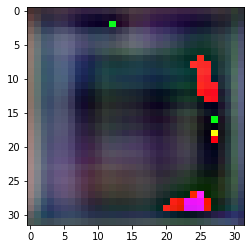

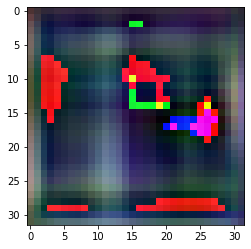

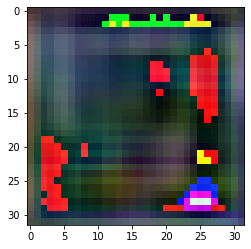

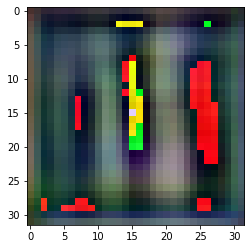

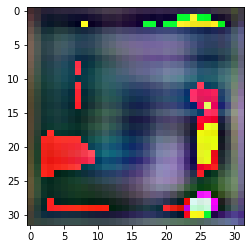

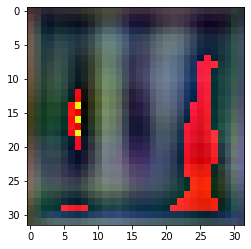

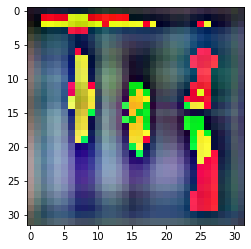

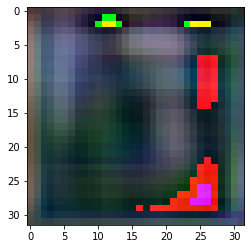

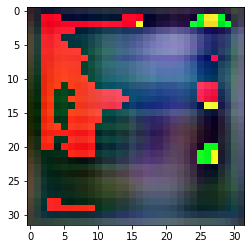

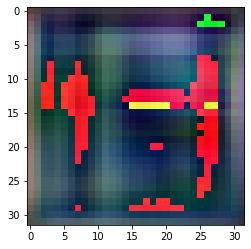

In [ ]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지 디코딩
generated_images = G.predict(random_latent_vectors )

for i in range(generated_images.shape[0]):
  img = image.array_to_img(generated_images[i] * 255. , scale = False)
  plt.figure()
  plt.imshow(img)

plt.show()